In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
damage_setting={'γ_2p': np.array([0, .0197*2*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

def simulate_emission(ξ_b, ξ_p, ξ_a, damage_setting, Kt, baseline):
    η = .032
    γ_1 = 1.7675/10000
    γ_2 = .0022*2
    α = 0.115
    ioverk = 0.09

    # Sovle for value function
    model_i, model = solve_value_function(ξ_b, ξ_p, ξ_a, damage_setting)

    n_damage = len(damage_setting['πd_o'])
    y_bar = model['y_grid'][-1]
    y_grid_short = model['y_grid']
    y_grid_long = model_i[0]['y_grid']
    
    σ_y = 1.2 * np.mean(model['θ'])
    # Simulation
    et, yt, _, _ = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                              θ=np.mean(model['θ']), y_start=np.mean(model['θ'])*290, T=100,
                              σ_y=σ_y, baseline=baseline)    

    Ct0 = (α - ioverk)*Kt[0]
    logSCCt = np.log(1000) + np.log(Ct0)  - (yt*γ_1 + γ_2/2.*yt**2) - np.log(et) + np.log(η) - np.log(1-η)
    return et, logSCCt

In [3]:
# Simulate capital process
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [4]:
et_baseline, logSCCt_baseline = simulate_emission(ξ_b=10000., ξ_p=10000., ξ_a=10000.,
                                damage_setting=damage_setting, Kt=Kt, baseline=True)
et_baseline_bp5, logSCCt_baseline_bp5 = simulate_emission(ξ_b=5., ξ_p=5., ξ_a=10000.,
                                    damage_setting=damage_setting, Kt=Kt, baseline=True)
et_baseline_b03p5, logSCCt_baseline_b03p5 = simulate_emission(ξ_b=.3, ξ_p=5., ξ_a=10000.,
                                      damage_setting=damage_setting, Kt=Kt, baseline=True)
et_baseline_b03p03, logSCCt_baseline_b03p03 = simulate_emission(ξ_b=.3, ξ_p=.3, ξ_a=10000.,
                                      damage_setting=damage_setting, Kt=Kt, baseline=True)

Converged. Total iteration 5000: LHS Error: 4.7850891112588556e-05; RHS Error 0.00011651066866451287
Converged. Total iteration 1502: LHS Error: 9.89787540817133e-09; RHS Error 0.0004825786078790015
Converged. Total iteration 1619: LHS Error: 9.928335487074946e-09; RHS Error 0.0022617438021297525
Converged. Total iteration 373: LHS Error: 9.398999800680485e-09; RHS Error 0.0006255945682015207
Converged. Total iteration 5000: LHS Error: 1.8262302382332507e-05; RHS Error 7.391525572446322e-05
Converged. Total iteration 1502: LHS Error: 9.870589234850513e-09; RHS Error 0.00047707481406719654
Converged. Total iteration 1619: LHS Error: 9.948232460033068e-09; RHS Error 0.0022398807654513105
Converged. Total iteration 443: LHS Error: 9.78230474402153e-09; RHS Error 0.000840732558392579
Converged. Total iteration 1460: LHS Error: 9.993600613711351e-09; RHS Error 8.62453001048008e-05
Converged. Total iteration 1507: LHS Error: 9.99949856250737e-09; RHS Error 0.00041269340939360105
Converged. T

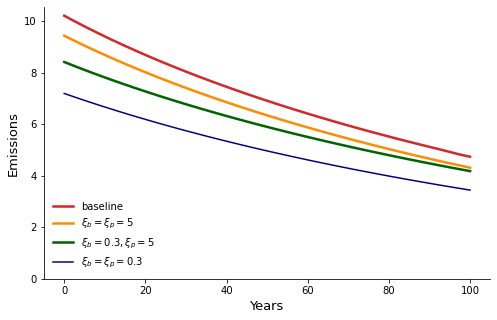

In [5]:
# Figure 7
fig = plt.figure(figsize=(8, 5))
plt.plot(et_baseline, label="baseline", color="tab:red", linewidth=2.5)
plt.plot(et_baseline_bp5, label="$ξ_b = ξ_p = 5$", color="darkorange", linewidth=2.5)
plt.plot(et_baseline_b03p5, label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen", linewidth=2.5)
plt.plot(et_baseline_b03p03, label="$ξ_b = ξ_p = 0.3$" , color="navy")

# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
plt.savefig("../plots/standardized/emission_three.pdf")

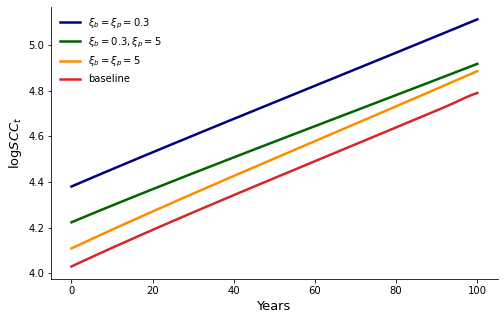

In [6]:
# Figure 8, baseline
fig = plt.figure(figsize=(8,5))

plt.plot(logSCCt_baseline_b03p03, label="$ξ_b = ξ_p = 0.3$", color="navy", linewidth=2.5)
plt.plot(logSCCt_baseline_b03p5, label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", linewidth=2.5)
plt.plot(logSCCt_baseline_bp5, label="$ξ_b = ξ_p = 5$", color="darkorange", linewidth=2.5)
plt.plot(logSCCt_baseline, label="baseline", color="tab:red", linewidth=2.5)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
plt.savefig("../plots/standardized/logscc.pdf")

In [7]:
et_worst_bp5, logSCCt_worst_bp5 = simulate_emission(ξ_b=5., ξ_p=5., ξ_a=10000.,
                                    damage_setting=damage_setting, Kt=Kt, baseline=False)
et_worst_b03p5, logSCCt_worst_b03p5 = simulate_emission(ξ_b=.3, ξ_p=5., ξ_a=10000.,
                                      damage_setting=damage_setting, Kt=Kt, baseline=False)
et_worst_b03p03, logSCCt_worst_b03p03 = simulate_emission(ξ_b=.3, ξ_p=.3, ξ_a=10000.,
                                      damage_setting=damage_setting, Kt=Kt, baseline=False)

Converged. Total iteration 5000: LHS Error: 1.8262302382332507e-05; RHS Error 7.391525572446322e-05
Converged. Total iteration 1502: LHS Error: 9.870589234850513e-09; RHS Error 0.00047707481406719654
Converged. Total iteration 1619: LHS Error: 9.948232460033068e-09; RHS Error 0.0022398807654513105
Converged. Total iteration 443: LHS Error: 9.78230474402153e-09; RHS Error 0.000840732558392579
Converged. Total iteration 1460: LHS Error: 9.993600613711351e-09; RHS Error 8.62453001048008e-05
Converged. Total iteration 1507: LHS Error: 9.99949856250737e-09; RHS Error 0.00041269340939360105
Converged. Total iteration 1622: LHS Error: 9.914472798300267e-09; RHS Error 0.001999718236809567
Converged. Total iteration 429: LHS Error: 9.839696168967293e-09; RHS Error 0.0008223350678815793
Converged. Total iteration 1460: LHS Error: 9.993600613711351e-09; RHS Error 8.62453001048008e-05
Converged. Total iteration 1507: LHS Error: 9.99949856250737e-09; RHS Error 0.00041269340939360105
Converged. Tota

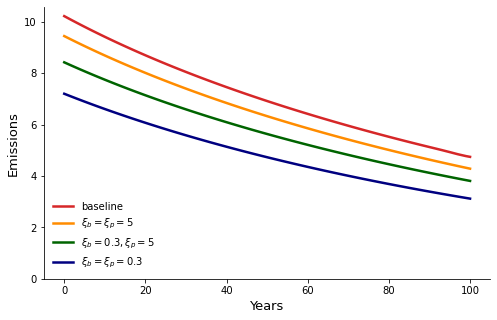

In [10]:
# Figure 7, worst case counterpart
fig = plt.figure(figsize=(8, 5))
plt.plot(et_baseline, label="baseline", color="tab:red", linewidth=2.5)
plt.plot(et_worst_bp5, label="$ξ_b = ξ_p = 5$", color="darkorange", linewidth=2.5)
plt.plot(et_worst_b03p5, label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen", linewidth=2.5)
plt.plot(et_worst_b03p03, label="$ξ_b = ξ_p = 0.3$" , color="navy", linewidth=2.5)

# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
plt.savefig("../plots/standardized/emission_three_worst.pdf")

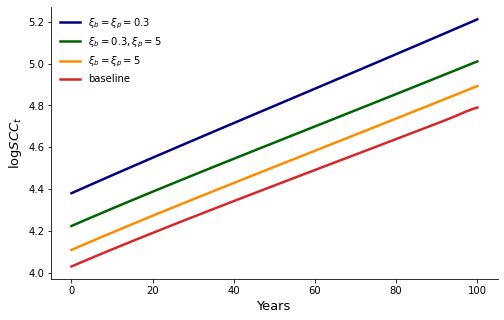

In [9]:
# Figure 8, worst case counterpart
fig = plt.figure(figsize=(8,5))

plt.plot(logSCCt_worst_b03p03, label="$ξ_b = ξ_p = 0.3$", color="navy", linewidth=2.5)
plt.plot(logSCCt_worst_b03p5, label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", linewidth=2.5)
plt.plot(logSCCt_worst_bp5, label="$ξ_b = ξ_p = 5$", color="darkorange", linewidth=2.5)
plt.plot(logSCCt_baseline, label="baseline", color="tab:red", linewidth=2.5)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
plt.savefig("../plots/standardized/logscc_worst.pdf")